# Exploring your harvested data

In this notebook we'll look at some ways of exploring the `results.csv` created by the Trove Newspaper and Gazette Harvester.

In [1]:
import os
import zipfile
from operator import itemgetter
from pathlib import Path

import altair as alt
import nltk
import pandas as pd
from textblob import TextBlob
from wordcloud import WordCloud

nltk.download("stopwords")
nltk.download("punkt")

stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /home/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/tim/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
%%capture
# Load variables from the .env file if it exists
# Use %%capture to suppress messages
%load_ext dotenv
%dotenv

## Loading the data

By default, this notebook will look for existing harvests in the `data` directory. If you want to use a harvest that downloaded previously, just upload the zipped harvest to the `data` directory and run the cell below. It will expand all the zipped files in the `data` directory.

In [ ]:
# Import a harvest zip file you've created previously
# First upload the zip file to the data directory, then run this cell

for zipped in Path("data").glob("*.zip"):
    with zipfile.ZipFile(zipped, "r") as zip_file:
        zip_file.extractall(Path("data", zipped.name[:-4]))

These functions open up a harvest and convert the `results.csv` into a dataframe for analysis.

In [4]:
def get_latest_harvest():
    """
    Get the timestamp of the most recent harvest.
    """
    harvests = sorted(
        [d for d in os.listdir("data") if os.path.isdir(os.path.join("data", d))]
    )
    return harvests[-1]


def open_harvest_data(timestamp=None):
    """
    Open the results of the specified harvest (most recent by default).

    Returns a DataFrame.
    """
    if not timestamp:
        timestamp = get_latest_harvest()
    df = pd.read_csv(
        os.path.join("data", timestamp, "results.csv"), parse_dates=["date"]
    )
    return df

Running `open_harvest_data()` without any parameters will load the most recent harvest. To load a different harvest, just supply the name of the directory containing the harvest (this will generally be a timestamp).

In [5]:
# In testing environment, open a test harvest
if os.getenv("GW_STATUS") == "dev":
    df = open_harvest_data("1655952487")
# Otherwise open most recent harvest
# Supply a harvest directory name to open a specific harvest
else:
    df = open_harvest_data()

## Examining the data

Let's have a peek at the dataset.

In [6]:
# .head() displays the first 5 rows of a dataframe
df.head()

article_id                                              title  \
0   100249640                           MR. WRAGGE'S PREDICTION.   
1   100252268  The "Forbes Times." SATURDAY, JUNE 22nd, 1912....   
2   100499840                                  WRAGGE'S ALMANAC.   
3   100503988                                      GENERAL NEWS.   
4   100621725                                WEATHER PROPHECIES.   

   newspaper_id                                    newspaper_title page  \
0           422      Forbes Times (NSW : 1899 - 1902; 1912 - 1920)    2   
1           422      Forbes Times (NSW : 1899 - 1902; 1912 - 1920)    4   
2           367                Goulburn Herald (NSW : 1881 - 1907)    2   
3           367                Goulburn Herald (NSW : 1881 - 1907)    2   
4           436  The Albury Banner and Wodonga Express (NSW : 1...   28   

        date category  words illustrated  corrections  \
0 1912-02-07  Article     30           N            0   
1 1912-06-22  Article    952           N            0   
2 1902-01-03  Article     82           N            0   
3 1902-09-05  Article   1043           N            1   
4 1903-02-13  Article    158           N            0   

                                             snippet  \
0  Mr. Wragge forecasts that until 1915 or 1916 t...   
1  it has been said that we Australians are the m...   
2  WE have received from the agents, Messrs. Gord...   
3  At the technological examination in May, last ...   
4  Mr. Wragge has given reasons for prophesying t...   

                                            url  \
0  https://nla.gov.au/nla.news-article100249640   
1  https://nla.gov.au/nla.news-article100252268   
2  https://nla.gov.au/nla.news-article100499840   
3  https://nla.gov.au/nla.news-article100503988   
4  https://nla.gov.au/nla.news-article100621725   

                                          page_url  
0  http://trove.nla.gov.au/newspaper/page/10517407  
1  http://trove.nla.gov.au/newspaper/page/10517639  
2   http://trove.nla.gov.au/newspaper/page/9423791  
3   http://trove.nla.gov.au/newspaper/page/9424299  
4  http://trove.nla.gov.au/newspaper/page/10848554

How many articles did we harvest?

In [7]:
df.shape[0]

3066

What's the earliest and latest publication date in the dataset?

In [8]:
df["date"].min()

Timestamp('1854-10-05 00:00:00')

In [9]:
df["date"].max()

Timestamp('1988-02-28 00:00:00')

How many different newspapers are represented in our dataset?

In [10]:
len(df["newspaper_id"].unique())

412

Which article has the most words?

In [11]:
df.loc[df["words"].idxmax()]

article_id                                               18381792
title                                                 Advertising
newspaper_id                                                   35
newspaper_title     The Sydney Morning Herald (NSW : 1842 - 1954)
page                                                           14
date                                          1953-08-22 00:00:00
category                                              Advertising
words                                                      150533
illustrated                                                     N
corrections                                                   242
snippet                                                       NaN
url                   https://nla.gov.au/nla.news-article18381792
page_url           http://trove.nla.gov.au/newspaper/page/1062896
Name: 1359, dtype: object

## Show the most common newspapers

Here we'll visualise the 25 most common newspapers in the dataset.

In [12]:
df_newspapers = (
    df.value_counts(["newspaper_title", "newspaper_id"]).to_frame().reset_index()
)
df_newspapers.columns = ["newspaper_title", "newspaper_id", "count"]
df_newspapers

newspaper_title  newspaper_id  count
0         The Telegraph (Brisbane, Qld. : 1872 - 1947)           840    272
1        The Sydney Morning Herald (NSW : 1842 - 1954)            35    164
2             The Mercury (Hobart, Tas. : 1860 - 1954)            10    137
3            The Brisbane Courier (Qld. : 1864 - 1933)            16    119
4            The Argus (Melbourne, Vic. : 1848 - 1957)            13     74
..                                                 ...           ...    ...
407           Ballidu-Wongan Budget (WA : 1927 - 1941)          1395      1
408                  Wickepin Argus (WA : 1910 - 1934)           820      1
409  Avon Argus and Cunderdin-Meckering-Tammin Mail...          1394      1
410       Avoca Mail (Vic. : 1863 - 1900; 1915 - 1918)           756      1
411                 World (Hobart, Tas. : 1918 - 1924)           861      1

[412 rows x 3 columns]

In [13]:
alt.Chart(df_newspapers[:25]).mark_bar().encode(
    x=alt.X("count:Q", title="Number of articles"),
    y=alt.Y("newspaper_title:N", title="Newspaper", sort="-x"),
    tooltip=[
        alt.Tooltip("newspaper_title:N", title="Newspaper"),
        alt.Tooltip("count:Q", title="Articles"),
    ],
)

alt.Chart(...)

## Show when the articles were published

In [14]:
df["year"] = df["date"].dt.year
df_years = df["year"].value_counts().to_frame().reset_index()
df_years.columns = ["year", "count"]
df_years

year  count
0   1902    984
1   1903    443
2   1914    104
3   1912     89
4   1913     78
..   ...    ...
83  1855      1
84  1864      1
85  1865      1
86  1866      1
87  1871      1

[88 rows x 2 columns]

In [15]:
alt.Chart(df_years).mark_line().encode(
    x=alt.X("year:Q", axis=alt.Axis(format="d")),
    y=alt.Y("count:Q"),
    tooltip=[
        alt.Tooltip("year", title="Year"),
        alt.Tooltip("count", title="Articles", format=",d"),
    ],
).properties(width=700)

alt.Chart(...)

## Make a simple word cloud from the article titles

In [16]:
df_titles = df.loc[(df["title"] != "No Title") & (df["title"] != "Advertising")]
# Get all the articles titles and turn them into a single string
title_text = df_titles["title"].str.lower().str.cat(sep=" ")

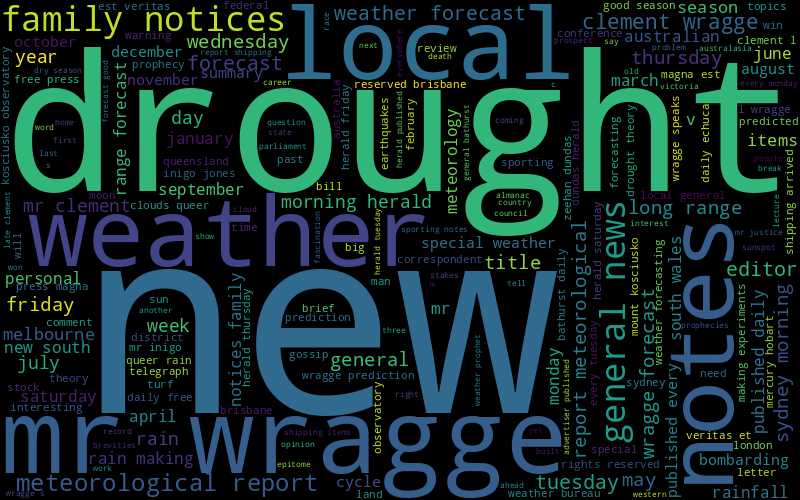

In [17]:
# Generate a word cloud image
wordcloud = WordCloud(width=800, height=500, collocations=True).generate(title_text)
wordcloud.to_image()

## Using TextBlob

In [18]:
blob = TextBlob(title_text)

In [19]:
word_counts = [
    [word, count]
    for word, count in blob.lower().word_counts.items()
    if word not in stopwords
]
word_counts = sorted(word_counts, key=itemgetter(1), reverse=True)[:25]
pd.DataFrame(word_counts, columns=["word", "count"]).style.format(
    {"count": "{:,}"}
).bar(subset=["count"], color="#d65f5f").set_properties(
    subset=["count"], **{"width": "300px"}
)

## Mapping newspaper locations

This makes use of a spreadsheet file that maps Trove newspaper titles to locations. Once we've loaded the spreadsheet we can use it to locate all of the harvested articles.

In [20]:
# Url of the Trove places spreadshseet
trove_places = "https://docs.google.com/spreadsheets/d/1rURriHBSf3MocI8wsdl1114t0YeyU0BVSXWeg232MZs/gviz/tq?tqx=out:csv&sheet=198244298"

# Open the CSV file with Pandas
place_df = pd.read_csv(trove_places)

In [21]:
df_located = pd.merge(
    df_newspapers, place_df, how="left", left_on="newspaper_id", right_on="title_id"
)

# There may be some newspapers that haven't been added to the locations dataset yet, so we'll drop them
df_located.dropna(axis=0, subset=["latitude"], inplace=True)

In [22]:
# Load Australian boundaries
australia = alt.topo_feature(
    "https://raw.githubusercontent.com/GLAM-Workbench/trove-newspapers/master/data/aus_state.geojson",
    feature="features",
)

# Create the map of Australia using the boundaries
aus_background = (
    alt.Chart(australia)
    .mark_geoshape(
        # Style the map
        fill="lightgray",
        stroke="white",
    )
    .project("equirectangular")
    .properties(width=600, height=600)
)

# Plot the places
points = (
    alt.Chart(df_located)
    .mark_circle(color="steelblue")
    .encode(
        # Set position of each place using lat and lon
        longitude="longitude:Q",
        latitude="latitude:Q",
        size=alt.Size(
            "count:Q",
            scale=alt.Scale(range=[0, 1000]),
            legend=alt.Legend(title="Number of articles"),
        ),
        # More details on hover
        tooltip=[
            alt.Tooltip("newspaper_title_x", title="Newspaper"),
            "latitude",
            "longitude",
            "count",
        ],
    )
    .properties(width=600, height=600)
)

# Combine map and points
alt.layer(aus_background, points)

alt.LayerChart(...)

----

Created by [Tim Sherratt](https://timsherratt.org) ([@wragge](https://twitter.com/wragge)) for the [GLAM Workbench](https://github.com/glam-workbench/).  
Support this project by [becoming a GitHub sponsor](https://github.com/sponsors/wragge?o=esb).
